### 1. Import Dependecies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Loading the data

In [2]:
X_train = np.load('artifacts/X_train.npz')['arr_0']
Y_train = np.load('artifacts/Y_train.npz')['arr_0']
X_test = np.load('artifacts/X_test.npz')['arr_0']
Y_test = np.load('artifacts/Y_test.npz')['arr_0']

In [3]:
X_train

array([[ 1.        ,  1.21525062, -0.47427882, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.        , -0.51525035, -0.47427882, ...,  0.        ,
         0.        ,  1.        ],
       [ 3.        ,  0.17695004, -0.47427882, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 3.        ,  0.86915043,  1.33937968, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        , -1.20745074,  0.43255043, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        , -0.66907266, -0.47427882, ...,  0.        ,
         0.        ,  1.        ]], shape=(712, 10))

### 3. Model Training

#### 3.1 Standard Logistic Regression

In [4]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [5]:
def log_regression(X, Y, lr=0.01, iterations=1000):
    n, m = X.shape        # n = samples, m = features
    w = np.random.randn(m)
    b0 = 0

    for epoch in range(iterations):
        # forward
        z = b0 + np.dot(X, w)
        Yhat = sigmoid(z)

        # stability (avoid log(0))
        eps = 1e-15
        Yhat = np.clip(Yhat, eps, 1 - eps)

        # residuals
        resid = Y - Yhat

        # gradients (averaged)
        grad_w = np.dot(X.T, resid) / n
        grad_b = np.mean(resid)

        # update
        w = w + lr * grad_w   # note: since resid = Y - Yhat, we add here
        b0 = b0 + lr * grad_b

        # cost (binary cross entropy)
        pos_component = np.sum(Y * np.log(Yhat))
        neg_component = np.sum((1 - Y) * np.log(1 - Yhat))
        cost = (-1/n) * (pos_component + neg_component)

        if epoch % 100 == 0:
            print(f"Iteration {epoch}: Bias={b0:.4f}, Cost={cost:.4f}")

    return w, b0


In [6]:
w, b0 = log_regression(X_train,Y_train)
w, b0 

Iteration 0: Bias=-0.0010, Cost=0.7819
Iteration 100: Bias=-0.0647, Cost=0.6987
Iteration 200: Bias=-0.0923, Cost=0.6455
Iteration 300: Bias=-0.1082, Cost=0.6034
Iteration 400: Bias=-0.1194, Cost=0.5700
Iteration 500: Bias=-0.1283, Cost=0.5442
Iteration 600: Bias=-0.1358, Cost=0.5247
Iteration 700: Bias=-0.1422, Cost=0.5099
Iteration 800: Bias=-0.1478, Cost=0.4985
Iteration 900: Bias=-0.1526, Cost=0.4896


(array([-0.84181995, -0.34322469,  0.07752609, -0.3891034 ,  0.394007  ,
         1.89035021,  0.02519647,  1.02864326,  0.25745224,  0.89156505]),
 np.float64(-0.15652082467902084))

In [7]:
def predict_proba(X, b0 ,w):
    z = b0 + np.dot(X, w)
    Y_proba = sigmoid(z)
    return Y_proba

In [8]:
def predict(X, w, b0, threshold=0.5):
    Y_proba = predict_proba(X, b0, w)
    return (Y_proba >= threshold).astype(int)

#### Evaluation Matrics

##### Confusion metrics

In [9]:
def compute_confusion_matrix(Y,Y_hat):
    TP = np.sum((Y == 1) & (Y_hat == 1))
    FP = np.sum((Y == 0) & (Y_hat == 1))
    TN = np.sum((Y == 0) & (Y_hat == 0))
    FN = np.sum((Y == 1) & (Y_hat == 0))
    return np.array([
                [TN,FP]
                ,[FN,TP]
                ],
                dtype=int
                )

In [10]:
Y_hat = predict(X_test, w, b0)
Y_proba = predict_proba(X_test, b0 ,w)

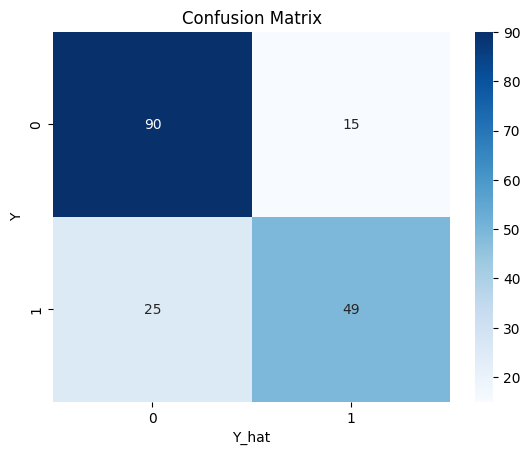

In [11]:
cm = compute_confusion_matrix(Y_test,Y_hat)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Y_hat')
plt.ylabel('Y')
plt.title('Confusion Matrix')
plt.show()

##### ROC curve

In [12]:
# initializing empty arrays for store each precision and recall values for precision recall curve
Precision= []
Recall = []

In [13]:
def roc_curve(Y,Y_proba):
    thresholds = np.linspace(1,0,200)

    tpr_list = []
    fpr_list = []

    for t in thresholds:
        y_hat = (Y_proba >= t).astype(int)
        
        TP = np.sum((Y == 1) & (y_hat == 1))
        FP = np.sum((Y == 0) & (y_hat == 1))
        TN = np.sum((Y == 0) & (y_hat == 0))
        FN = np.sum((Y == 1) & (y_hat == 0))

        tpr = TP / (TP + FN)
        fpr = FP / (FP + TN)

        if (TP + FP) == 0:
            precision = 0 
        else:
            precision = TP / (TP + FP)

        recall = TP / (TP +FN)
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        Precision.append(precision)
        Recall.append(recall)

    return np.array(tpr_list), np.array(fpr_list), np.array(thresholds)

In [14]:
tpr, fpr, _ = roc_curve(Y_test,Y_proba)

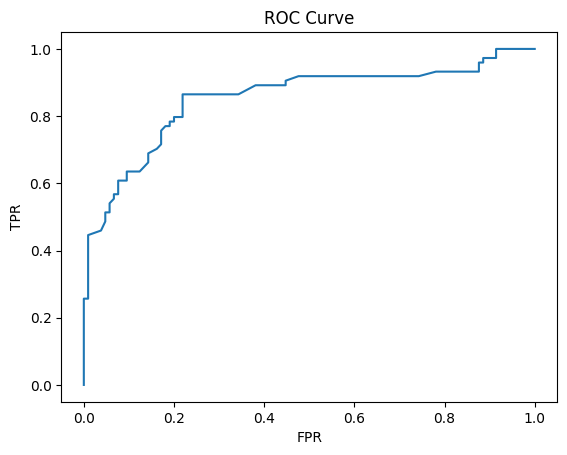

In [15]:
plt.plot(fpr, tpr, label='LogReg')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

In [16]:
auc = np.trapezoid(tpr, fpr)
print(f"AUC: {auc}")

AUC: 0.8525740025740026
